In [1]:
from BorderModel import IncrementalModel, run_Incremental
from BorderQuery import select_features, select_mungedata_simple, select_mungedata
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import pprint
import itertools
import pdb
import random

In [2]:
%load_ext autoreload
%autoreload 2

### Initialize for parallel operations

In [3]:
import os
from ipyparallel import Client
rc = Client()
dview = rc[:]

# set proper working directory on all clients
cwd = os.getcwd()
dview.map(os.chdir, [cwd] * 32)
# print(dview.apply_sync(os.getcwd))

with dview.sync_imports():
    import datetime
    from BorderModel import IncrementalModel, run_Incremental
    from BorderQuery import select_features, select_mungedata_simple, select_mungedata
    from sklearn.ensemble import ExtraTreesRegressor
    from sklearn.grid_search import GridSearchCV

importing datetime on engine(s)
importing IncrementalModel,run_Incremental from BorderModel on engine(s)
importing select_features,select_mungedata_simple,select_mungedata from BorderQuery on engine(s)
importing ExtraTreesRegressor from sklearn.ensemble on engine(s)
importing GridSearchCV from sklearn.grid_search on engine(s)


In [4]:
from BorderModel import IncrementalModel, run_Incremental
with dview.sync_imports():
    from BorderModel import IncrementalModel, run_Incremental
import random

def create_train_test(year, train_length=2):
    '''
    IN 
        years: list of years to predict
        train_length: number of years to train
    '''
    train_start = datetime.date(year - train_length, 1, 1).strftime('%Y-%m-%d')
    train_end = datetime.date(year, 1, 1).strftime('%Y-%m-%d')
    test_start = datetime.date(year, 1, 1).strftime('%Y-%m-%d')
    test_end = datetime.date(year + 1, 1, 1).strftime('%Y-%m-%d')
    return train_start, train_end, test_start, test_end
    
def compare_years_parallel(model, xing, munger_id, years):
    prlist = {}
    for year in years:
        cpu = random.randint(0, 31)
        train_start, train_end, test_start, test_end = create_train_test(year, 2)

        prlist[year] = rc[cpu].apply_async(run_Incremental, model, munger_id, xing,  
                                           train_start, train_end, 
                                           test_start, test_end)
        
    return prlist

importing IncrementalModel,run_Incremental from BorderModel on engine(s)


In [37]:
def model_plot(model, start, end):
    plt.figure(figsize=(16,4))
    baseline = model.baseline()
    ensemble = model.ensemble()
    actuals = model.actual
    yhat = model.y_predict
    
    plt.plot(actuals[(actuals.index.date>=start) & (actuals.index.date<end)], label='actuals')
    plt.plot(baseline[(baseline.index.date>=start) & (baseline.index.date<end)], label='baseline')
    plt.plot(yhat[(yhat.index.date>=start) & (yhat.index.date<end)], label='predictions')
    plt.plot(ensemble[(ensemble.index.date>=start) & (ensemble.index.date<end)], label='ensemble')
    plt.legend();

## Pacific Crossing

### Tuned for 2015

In [88]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, max_features='sqrt', max_depth=20)
pr5_tuned = compare_years_parallel(model, 5, 3, range(2011, 2016))

In [96]:
model5_tuned = {}
for year in range(2011, 2016):
    model5_tuned[year] = pr5_tuned[year].get(1)

In [97]:
for year in range(2011, 2016):
    print year
    print model5_tuned[year].score()

2011
{'model': 0.42965509214215614, 'ensemble': 0.52877829027700607, 'baseline': 0.50830951929768831}
2012
{'model': 0.47966607705882247, 'ensemble': 0.59494750831210763, 'baseline': 0.6264414468772701}
2013
{'model': 0.39322658042436331, 'ensemble': 0.50464539760127458, 'baseline': 0.57215536973016168}
2014
{'model': 0.51736679457973112, 'ensemble': 0.59632476018810343, 'baseline': 0.51290499913254095}
2015
{'model': 0.32035822603068875, 'ensemble': 0.4092626339974389, 'baseline': 0.23074703434185284}


### Basic model

In [41]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
pr5 = compare_years_parallel(model, 5, 3, range(2011, 2016))

In [43]:
pr5[2011].ready()

True

In [44]:
model5 = {}
for year in range(2011, 2016):
    model5[year] = pr5[year].get(1)

In [45]:
for year in range(2011, 2016):
    print year
    print model5[year].score()

2011
{'model': 0.50272391640586767, 'ensemble': 0.55445150847805791, 'baseline': 0.50830951929768831}
2012
{'model': 0.6226911033749849, 'ensemble': 0.6467626352425575, 'baseline': 0.6264414468772701}
2013
{'model': 0.61602199121891088, 'ensemble': 0.60156287332057834, 'baseline': 0.57215536973016168}
2014
{'model': 0.58057294885716781, 'ensemble': 0.5985847730701962, 'baseline': 0.51290499913254095}
2015
{'model': 0.31564682924980603, 'ensemble': 0.31952530575054905, 'baseline': 0.23074703434185284}


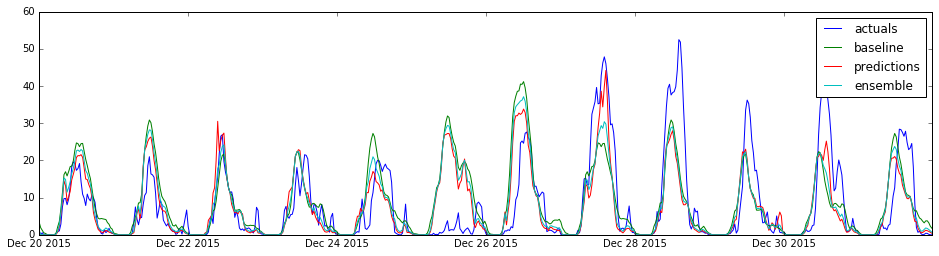

In [47]:
model_plot(model5[2015], dt.date(2015, 12, 20), dt.date(2016, 1, 2))

## Peace Arch

### Tuned for 2015

In [5]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, max_features='sqrt', max_depth=20)
pr1_tuned = compare_years_parallel(model, 1, 3, range(2011, 2016))

In [20]:
pr1_tuned[2012].ready()

False

In [21]:
model1_tuned = {}
for year in range(2011, 2016):
    model1_tuned[year] = pr1_tuned[year].get(1)

In [22]:
for year in range(2011, 2016):
    print year
    print model1_tuned[year].score()

2011
{'model': 0.038492288660850971, 'ensemble': 0.4043744643427194, 'baseline': 0.39385165054016535}
2012
{'model': 0.39728615743820161, 'ensemble': 0.55335776748762, 'baseline': 0.60900901758379433}
2013
{'model': 0.39901062661572828, 'ensemble': 0.54426734340455751, 'baseline': 0.61360307915900703}
2014
{'model': 0.49878736493931397, 'ensemble': 0.58793061924875945, 'baseline': 0.56996406060235849}
2015
{'model': 0.23825084975941924, 'ensemble': 0.32668323926055243, 'baseline': 0.1059067680212642}


### Basic model

In [7]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
pr1 = compare_years_parallel(model, 1, 3, range(2011, 2016))

In [13]:
pr1[2014].ready()

True

In [23]:
model1 = {}
for year in range(2011, 2016):
    model1[year] = pr1[year].get(1)

In [24]:
for year in range(2011, 2016):
    print year
    print model1[year].score()

2011
{'model': 0.070369330637410354, 'ensemble': 0.38470254340419319, 'baseline': 0.39385165054016535}
2012
{'model': 0.54009484355699411, 'ensemble': 0.61794260595015427, 'baseline': 0.60900901758379433}
2013
{'model': 0.63819687704912964, 'ensemble': 0.63824215930254291, 'baseline': 0.61360307915900703}
2014
{'model': 0.59857446885568166, 'ensemble': 0.61209538063032998, 'baseline': 0.56996406060235849}
2015
{'model': 0.15690952294286087, 'ensemble': 0.18790675428589954, 'baseline': 0.1059067680212642}


In [103]:
pr1[2011].get(1).score()

{'baseline': 0.39385165054016535,
 'ensemble': 0.38071787318738071,
 'model': 0.055917597505885652}

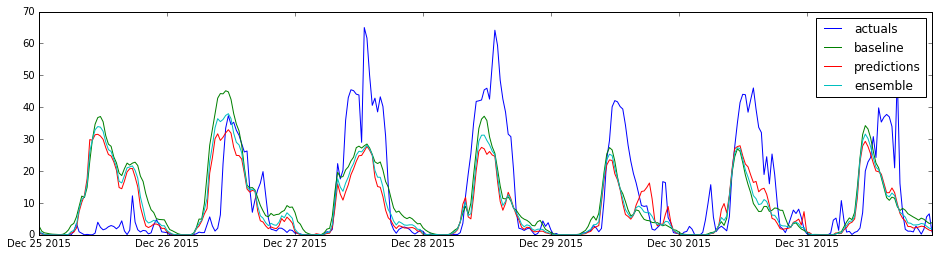

In [40]:
model_plot(model1[2015], dt.date(2015, 12, 25), dt.date(2016, 1, 1))

## Lynden

### Tuned for 2015

In [25]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, max_features='sqrt', max_depth=20)
pr16_tuned = compare_years_parallel(model, 16, 3, range(2013, 2016))

In [ ]:
pr16_tuned[2014].ready()

In [29]:
model16_tuned = {}
for year in range(2013, 2016):
    model16_tuned[year] = pr16_tuned[year].get(1)

In [32]:
for year in range(2015, 2016):
    print year
    print model16_tuned[year].score()

2015
{'model': -0.10865491301958063, 'ensemble': 0.030034226709336864, 'baseline': -0.47527592569072796}


### Basic model

In [26]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
pr16 = compare_years_parallel(model, 16, 3, range(2013, 2016))

In [30]:
pr16[2013].ready()

True

In [33]:
model16 = {}
for year in range(2013, 2016):
    model16[year] = pr16[year].get(1) 

In [35]:
for year in range(2015, 2016):
    print year
    print model16[year].score()

2015
{'model': -0.26025832125032711, 'ensemble': -0.19609460620791497, 'baseline': -0.47527592569072796}


# Conclusions

* Basic model with ensemble is better than tuned model for all years except 2011
* Prediction shape better resembles real behavior
* Lynden is not well predicted by model